# Project 1 Question 2

In this part, we evaluate an American put option. Assume that $T=1$, $S_0=10$, $\mu=5\%$, $\sigma=20\%$, and the risk-free rate $r=2\%$. Use $N=5000$ and a strike $K=10$.

Since the stochastic dynamic for the asset price process is $S_{t_k}=S_{t_{k-1}}e^{r\Delta t+\sigma\sqrt{\Delta t}}$ when $\epsilon_k=+1$, then the up factor is $u=\frac{S_{t_k}}{S_{t_{k-1}}}=e^{r\Delta t+\sigma\sqrt{\Delta t}}$ and the down factor is just $d=\frac{1}{u}$.

For the risk-neutral measure approach, we have $\mathbb{Q}(\epsilon_k=+1)=\frac{e^{r\Delta t} - d}{u - d} = \frac{1 - e^{-\sigma\sqrt{\Delta t}}}{e^{\sigma\sqrt{\Delta t}} - e^{-\sigma\sqrt{\Delta t}}}$

For the real-world measure approach, we have $\mathbb{P}(\epsilon_k=+1)=\frac{1}{2}\left(1+\frac{(\mu - r) - \frac{1}{2}\sigma^2}{\sigma}\sqrt{\Delta t}\right)$

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Part (a)

Implement the valuation and exercise boundary of the American put option with $B$ as the numéraire.

### i.

Plot the exercise boundary as a function of $t$.


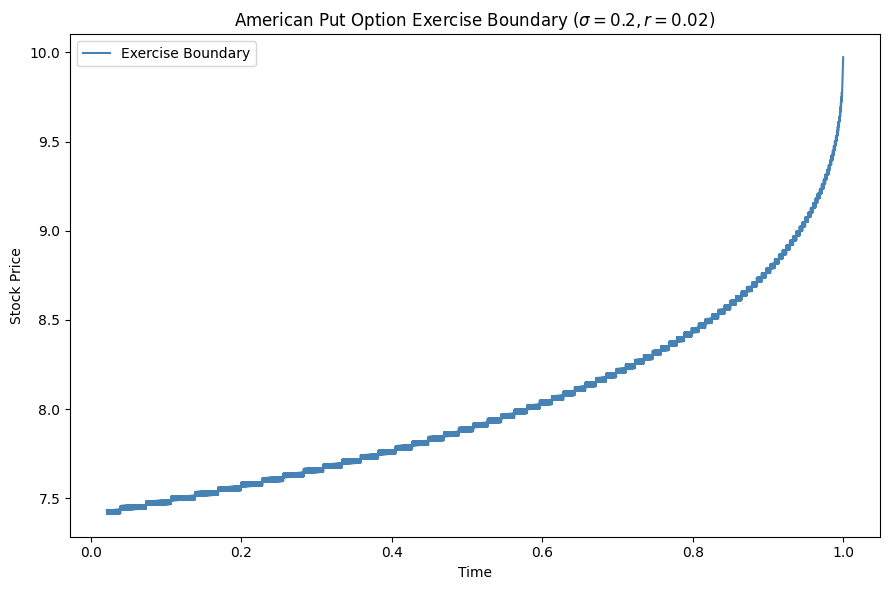

In [19]:
def plot_exercise_boundary(sigma, r, ax, T=1, S0=10, K=10, mu=0.05, N=5000):

    # Time step
    dt = T / N
    time_steps = np.linspace(0, 1, N + 1)

    # Up and down factors (u and d)
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))

    # Risk-neutral up-branch probability
    p_risk_neutral = (1 - np.exp(-sigma * np.sqrt(dt))) / (
        np.exp(sigma * np.sqrt(dt)) - np.exp(-sigma * np.sqrt(dt))
    )

    # Physical measure probability of an up move
    p_physical = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(dt))

    # Initialize stock tree and option value arrays
    stock_tree = np.zeros((N + 1, N + 1))
    option_value = np.zeros((N + 1, N + 1))

    # Binomial tree for stock prices
    stock_tree[0, 0] = S0
    for i in range(1, N+1):
        stock_tree[i, 0] = stock_tree[i-1, 0] * d
        for j in range(1, i+1):
            stock_tree[i, j] = stock_tree[i-1, j-1] * u

    # Initialize option value at maturity (put option payoff)
    option_value[N, :] = np.maximum(K - stock_tree[N, :], 0)

    # Backward induction using risk-neutral measure to calculate option values
    discount_factor = np.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        option_value[i, :i + 1] = discount_factor * (
            p_risk_neutral * option_value[i + 1, 1:i + 2]
            + (1 - p_risk_neutral) * option_value[i + 1, :i + 1]
        )
        # Intrinsic value for early exercise
        intrinsic_value = K - stock_tree[i, :i + 1]
        # Take max between intrinsic value and continuation value
        option_value[i, :i + 1] = np.maximum(option_value[i, :i + 1], intrinsic_value)
    premium = option_value[0, 0]

    # Exercise boundary calculation
    exercise_boundary = []
    for i in range(len(stock_tree)):
        intrinsic_value = K - stock_tree[i, :i+1]
        optimal_indices = np.where(option_value[i, :i+1] == intrinsic_value)[0]
        if len(optimal_indices) > 0:
            boundary_price = stock_tree[i, optimal_indices[-1]]
        else:
            boundary_price = np.nan
        exercise_boundary.append([time_steps[i], boundary_price])  # Use normalized time steps
    exercise_boundary = np.array(exercise_boundary)

    # Plot the exercise boundary
    ax.plot(exercise_boundary[:, 0], exercise_boundary[:, 1],
            label="Exercise Boundary", color="steelblue")
    ax.set_title(f"American Put Option Exercise Boundary ($\sigma={sigma}, r={r}$)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Stock Price")
    ax.legend()

    valid_indices = ~np.isnan(exercise_boundary[:, 1])
    boundary_time = (np.arange(N + 1) * dt)[valid_indices]
    boundary_prices = exercise_boundary[:, 1][valid_indices]

    return exercise_boundary, boundary_time, boundary_prices, premium

# Call the function with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot_exercise_boundary(sigma=0.2, r=0.02, ax=ax)
plt.tight_layout()
plt.show()

### ii.

Generate two sample paths where in sample path

(1) the option is exercised early (say around $t=\frac{1}{2}$),

(2) the option is not exercised.

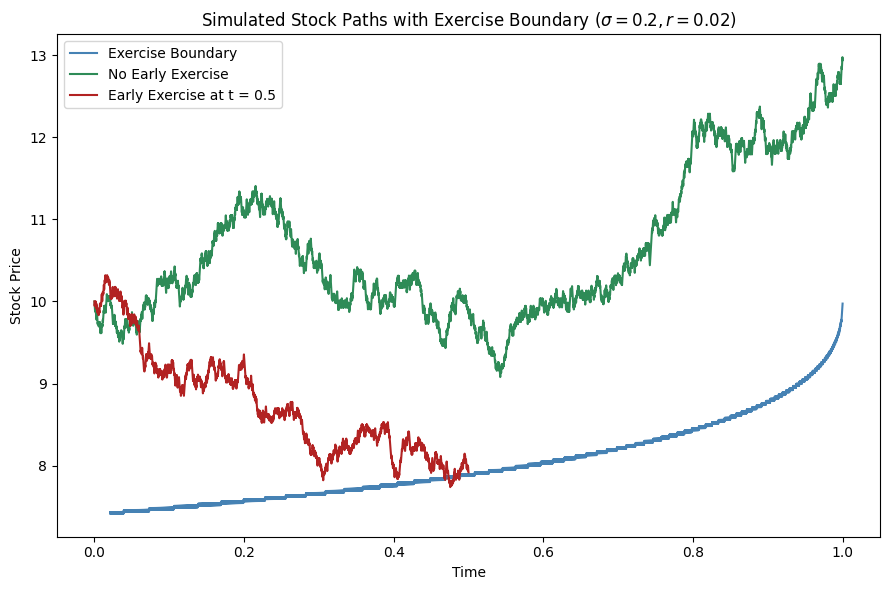

In [20]:
def generate_path(S0, N, u, d, p):
    """
    Generates a single path based on up/down moves.
    """
    path = np.zeros(N + 1)
    path[0] = S0  # Initial stock price

    # Generate path using the provided logic
    for j in range(1, N + 1):
        if np.random.rand() < p:  # Up move
            path[j] = path[j - 1] * u
        else:  # Down move
            path[j] = path[j - 1] * d

    return path

def generate_paths_with_exercise_boundary(sigma, r, ax, T=1, S0=10, K=10, mu=0.05, N=5000):
    # Time step
    dt = T / N
    time_steps = np.linspace(0, T, N + 1)

    # Up and down factors (u and d)
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))

    # Physical measure probability of an up move
    p_physical = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(dt))

    # Get exercise boundary
    boundary, time, prices, premium = plot_exercise_boundary(sigma, r, ax)

    # Simulate Path 1: No early exercise (must stay above boundary)
    path_no_exercise = generate_path(S0, N, u, d, p_physical)

    # Ensure the path stays above the boundary
    for i in range(1, N + 1):
        if path_no_exercise[i] < boundary[i, 1]:
            path_no_exercise[i] = path_no_exercise[i - 1]  # Hold previous price

    # Simulate Path 2: Find a path that touches the boundary at t = 0.5 and stops
    path_early_exercise = None
    T_hit = 0.5
    N_hit = int(N * (T_hit / T))

    # Keep generating paths until one touches the boundary at t = 0.5
    while path_early_exercise is None:
        candidate_path = generate_path(S0, N_hit, u, d, p_physical)

        # Check if the candidate path touches the boundary at t = 0.5
        if math.isclose(candidate_path[N_hit], boundary[N_hit, 1], rel_tol=0.01):
            path_early_exercise = candidate_path  # Use this path

    # Plot the simulated stock paths
    ax.plot(time_steps, path_no_exercise, label="No Early Exercise", color="seagreen")
    ax.plot(np.linspace(0, T_hit, len(path_early_exercise)), path_early_exercise,
            label="Early Exercise at t = 0.5", color="firebrick")

    ax.set_title(f"Simulated Stock Paths with Exercise Boundary ($\sigma={sigma}, r={r}$)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Stock Price")
    ax.legend()

    return path_no_exercise, path_early_exercise

# Plot the paths
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
np.random.seed(0)  # For reproducibility
generate_paths_with_exercise_boundary(sigma=0.2, r=0.02, ax=ax, T=1, S0=10, K=10, mu=0.05, N=5000)
plt.tight_layout()
plt.show()


### iii.

Along the two sample paths above, plot the hedging strategy that a trader would use to hedge the option as a function of time.

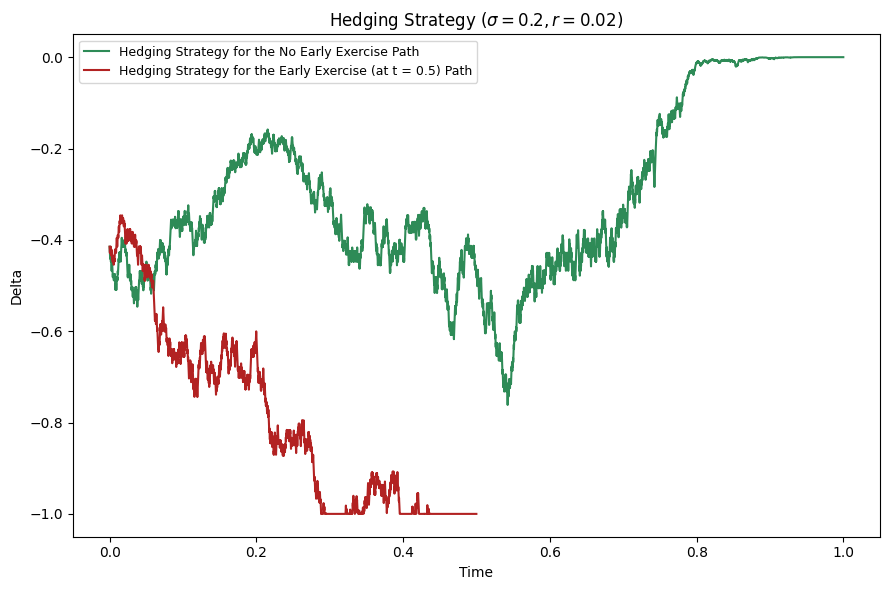

In [21]:
def get_paths_without_plotting(sigma, r, T=1, S0=10, K=10, mu=0.05, N=5000):
    """Extract paths without displaying any plot."""
    # Create a hidden figure to avoid plotting
    fig, ax = plt.subplots()
    plt.close(fig)  # Close the figure to prevent display

    # Generate the paths
    path_no_exercise, path_early_exercise = generate_paths_with_exercise_boundary(
        sigma, r, ax, T, S0, K, mu, N
    )

    return path_no_exercise, path_early_exercise

def plot_delta_hedging(sigma, r, ax, T=1, S0=10, K=10, mu=0.05, N=5000):

    # Time step
    dt = T / N

    # Up and down factors (u and d)
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))

    # Risk-neutral up-branch probability
    p_risk_neutral = (1 - np.exp(-sigma * np.sqrt(dt))) / (
        np.exp(sigma * np.sqrt(dt)) - np.exp(-sigma * np.sqrt(dt))
    )

    # Physical measure probability of an up move
    p_physical = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(dt))

    # Initialize stock tree and option value arrays
    stock_tree = np.zeros((N + 1, N + 1))
    option_value = np.zeros((N + 1, N + 1))

    # Binomial tree for stock prices
    stock_tree[0, 0] = S0
    for i in range(1, N+1):
        stock_tree[i, 0] = stock_tree[i-1, 0] * d
        for j in range(1, i+1):
            stock_tree[i, j] = stock_tree[i-1, j-1] * u

    # Initialize option value at maturity (put option payoff)
    option_value[N, :] = np.maximum(K - stock_tree[N, :], 0)

    # Backward induction using risk-neutral measure to calculate option values
    discount_factor = np.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        option_value[i, :i + 1] = discount_factor * (
            p_physical * option_value[i + 1, 1:i + 2]
            + (1 - p_physical) * option_value[i + 1, :i + 1]
        )
        # Intrinsic value for early exercise
        intrinsic_value = K - stock_tree[i, :i + 1]
        # Take max between intrinsic value and continuation value
        option_value[i, :i + 1] = np.maximum(option_value[i, :i + 1], intrinsic_value)
    
    path_no_exercise, path_early_exercise = get_paths_without_plotting(sigma, r)

    def delta_hedging(path, V=option_value, S=stock_tree):
        time_steps = np.arange(len(path))

        # broadcasting
        stock_indices = np.argmin(np.abs(S[time_steps, :len(path)] - path[:, None]), axis=1)
        S_up = S[time_steps[1:], stock_indices[:len(path) - 1]]
        S_down = S[time_steps[1:], stock_indices[:len(path) - 1] + 1]

        V_up = V[time_steps[1:], stock_indices[:len(path) - 1]]
        V_down = V[time_steps[1:], stock_indices[:len(path) - 1] + 1]

        # deltas
        delta = np.where(S_up != S_down, (V_up - V_down) / (S_up - S_down), 0)

        return delta
    
    # Get deltas
    deltas_no_exercise = delta_hedging(path_no_exercise)
    deltas_early_exercise = delta_hedging(path_early_exercise)

    times = np.linspace(0, T, N+1)

    # Plot hedging
    ax.plot(times[:len(deltas_no_exercise)], deltas_no_exercise,
            label='Hedging Strategy for the No Early Exercise Path', color="seagreen")
    ax.plot(times[:len(deltas_early_exercise)], deltas_early_exercise,
            label='Hedging Strategy for the Early Exercise (at t = 0.5) Path', color="firebrick")
    ax.set_title(f"Hedging Strategy ($\sigma={sigma}, r={r}$)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Delta")
    ax.legend(loc='upper left', prop={'size': 9})

# Plot the paths
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
np.random.seed(0)
plot_delta_hedging(sigma=0.2, r=0.02, ax=ax, T=1, S0=10, K=10, mu=0.05, N=5000)
plt.tight_layout()
plt.show()

### iv.

Illustrate how the results in i, ii, and iii vary as volatility and risk-free rate change (pari-wise). *[For example, $\sigma=10\%,20\%,30\%$ and $r=0\%,2\%,4\%$]*

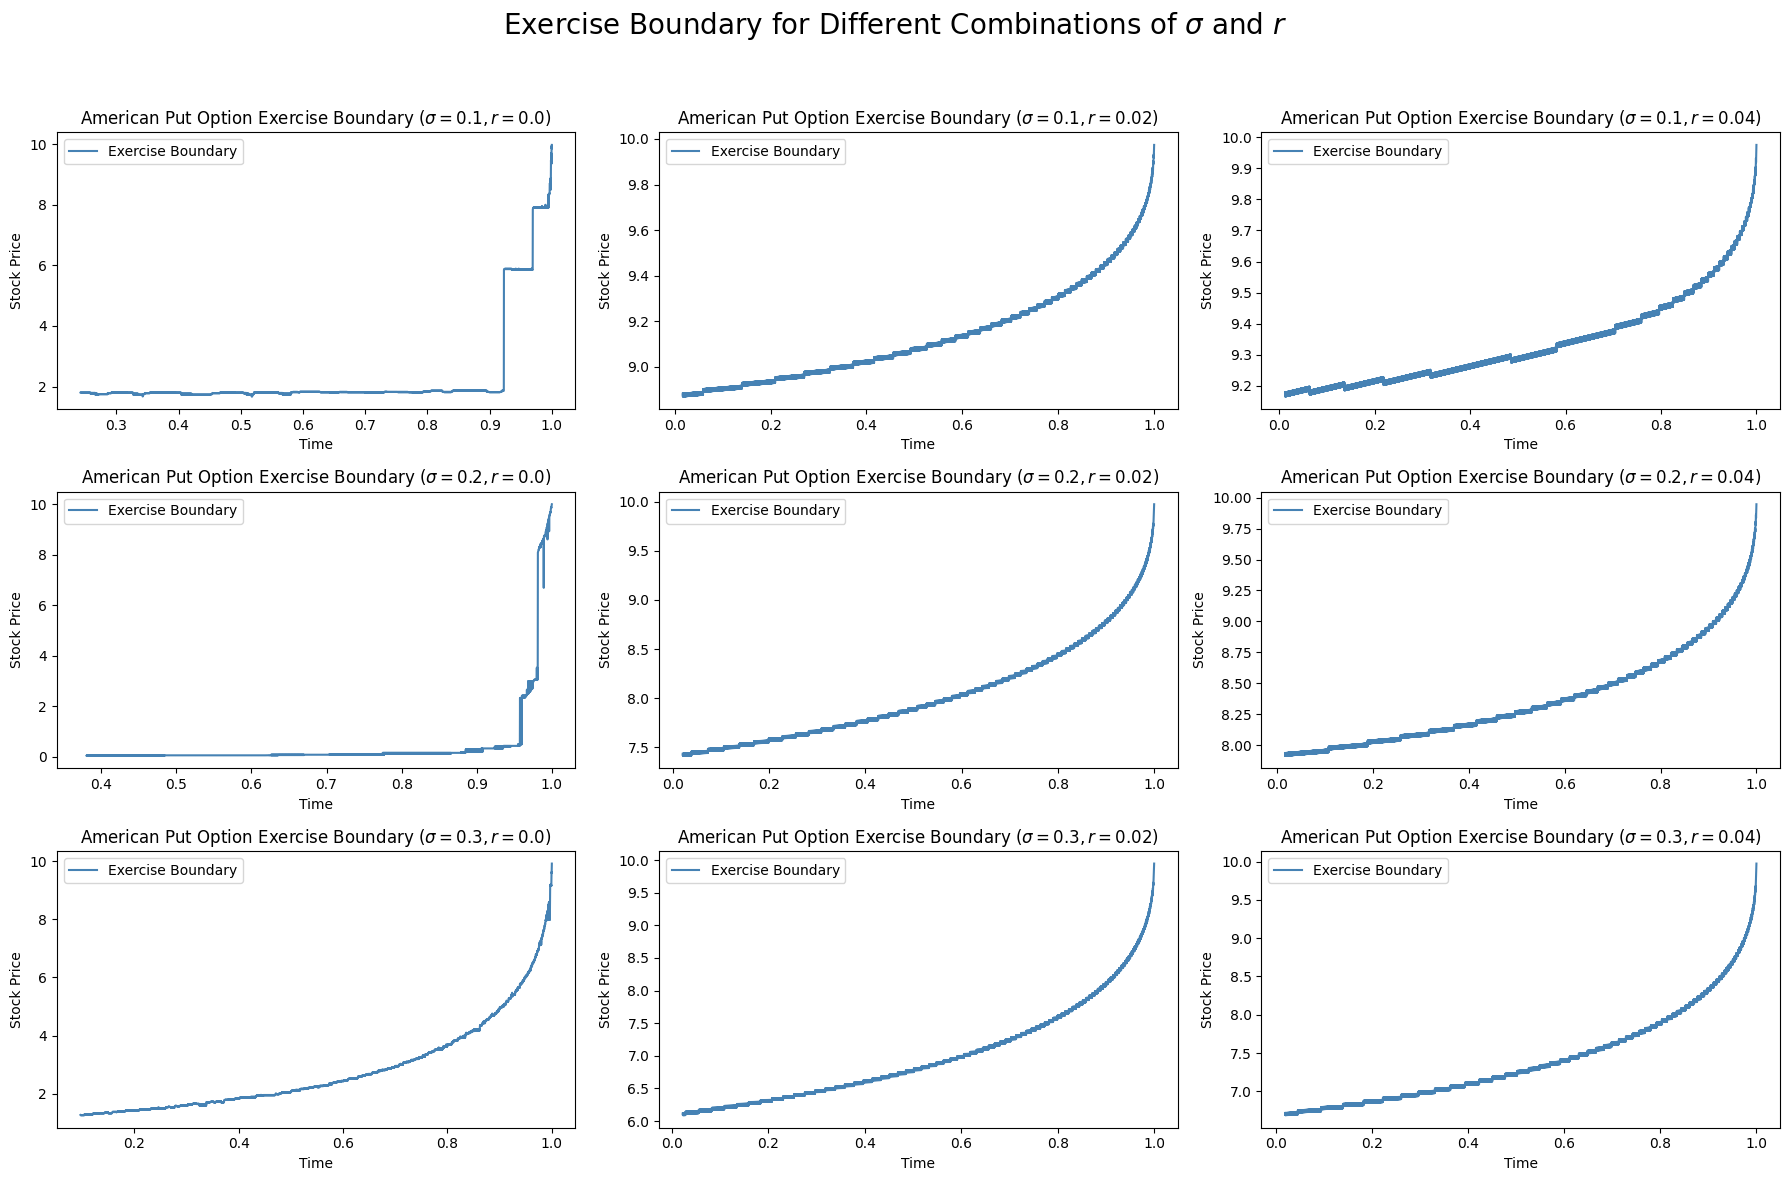

In [22]:
# Set values for σ (volatility) and r (risk-free rate)
sigma_values = [0.10, 0.20, 0.30]  # 10%, 20%, 30%
r_values = [0.00, 0.02, 0.04]      # 0%, 2%, 4%

# Create a 3x3 grid of subplots to plot for each combination of σ and r
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Exercise Boundary for Different Combinations of $\sigma$ and $r$", fontsize=20)

# Loop over all combinations of σ and r and plot in each subplot
for i, sigma in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        ax = axes[i, j]  # Select the appropriate subplot
        plot_exercise_boundary(sigma, r, ax=ax)  # Call the function with the specific axis

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

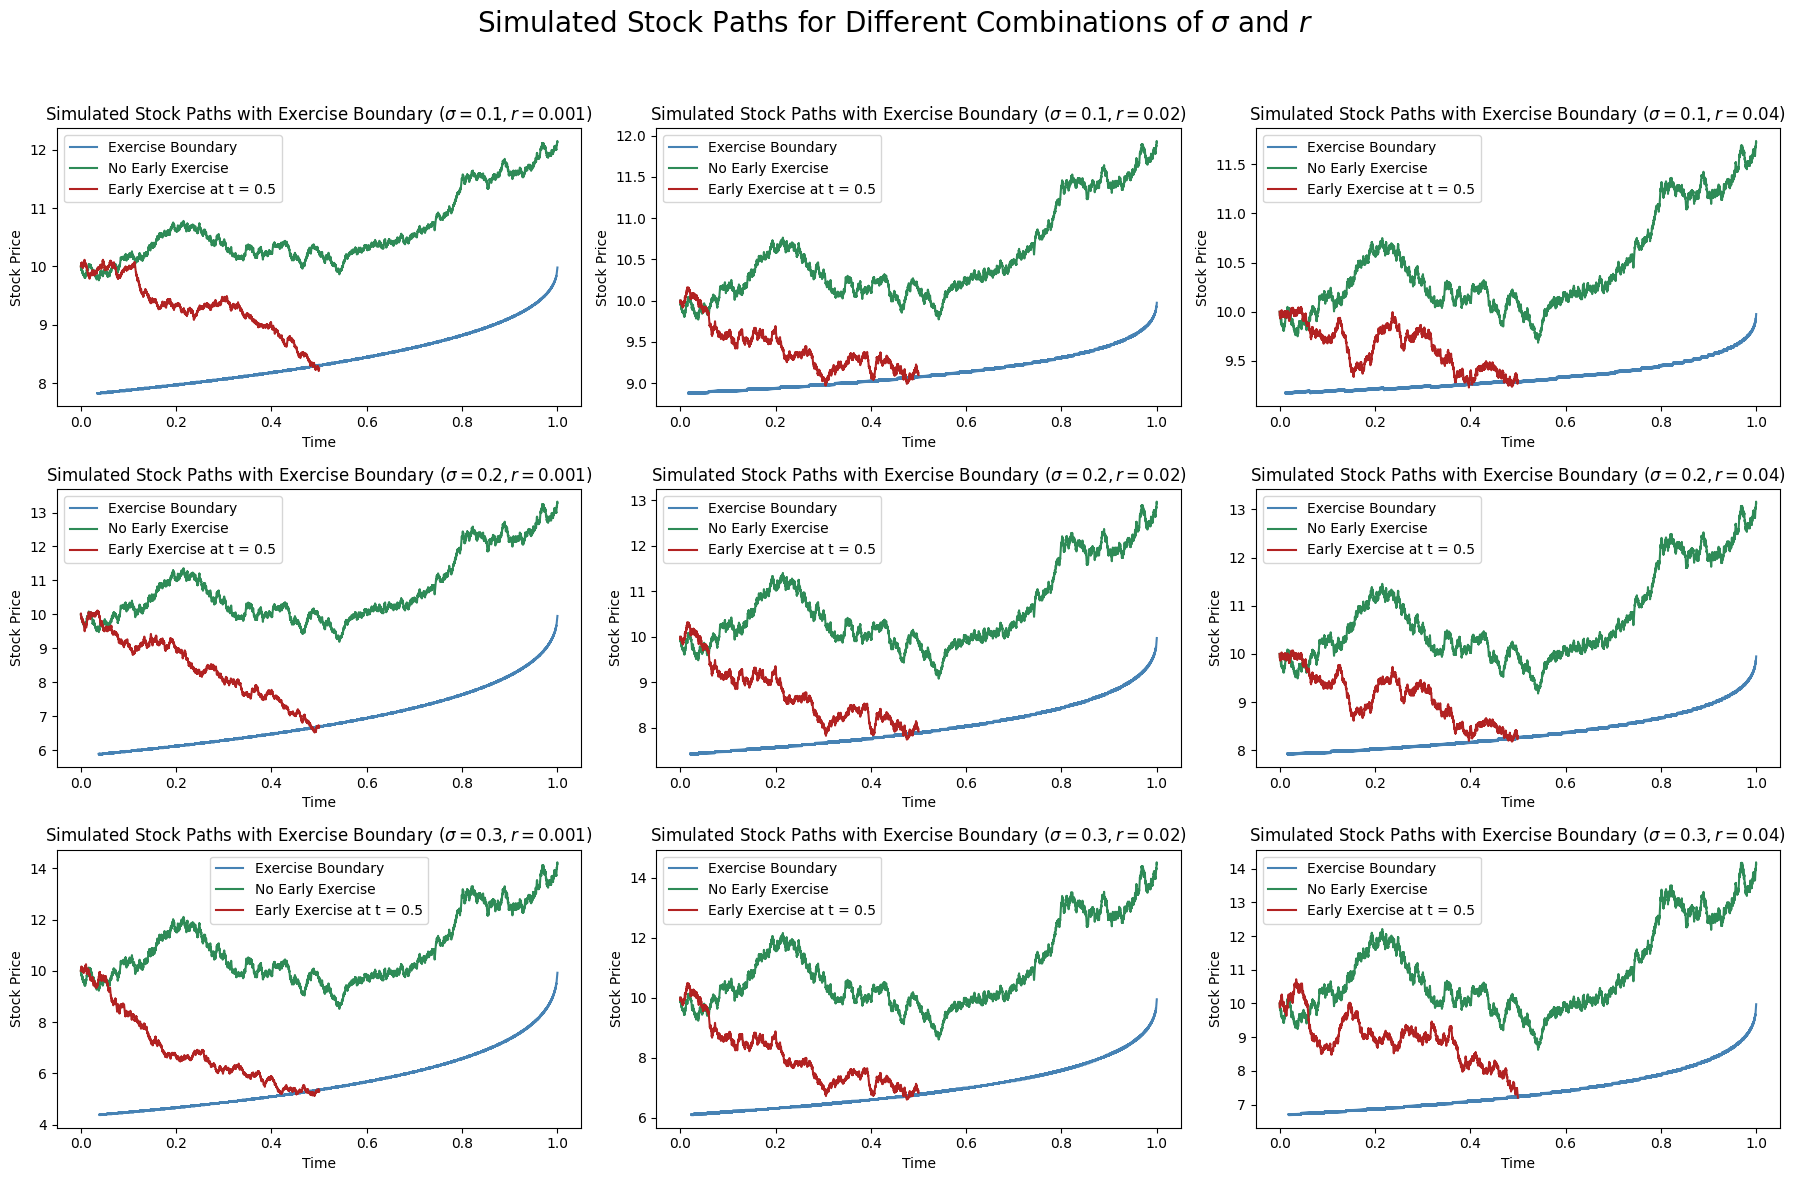

In [23]:
# Set values for σ (volatility) and r (risk-free rate)
sigma_values = [0.10, 0.20, 0.30]  # 10%, 20%, 30%
r_values = [0.001, 0.02, 0.04]      # 0%, 2%, 4%

# Create a 3x3 grid of subplots to plot for each combination of σ and r
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Simulated Stock Paths for Different Combinations of $\sigma$ and $r$", fontsize=20)

# Loop over all combinations of σ and r and plot in each subplot
for i, sigma in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        ax = axes[i, j]  # Select the appropriate subplot
        np.random.seed(0)
        generate_paths_with_exercise_boundary(sigma, r, ax=ax)  # Call the function with the specific axis

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

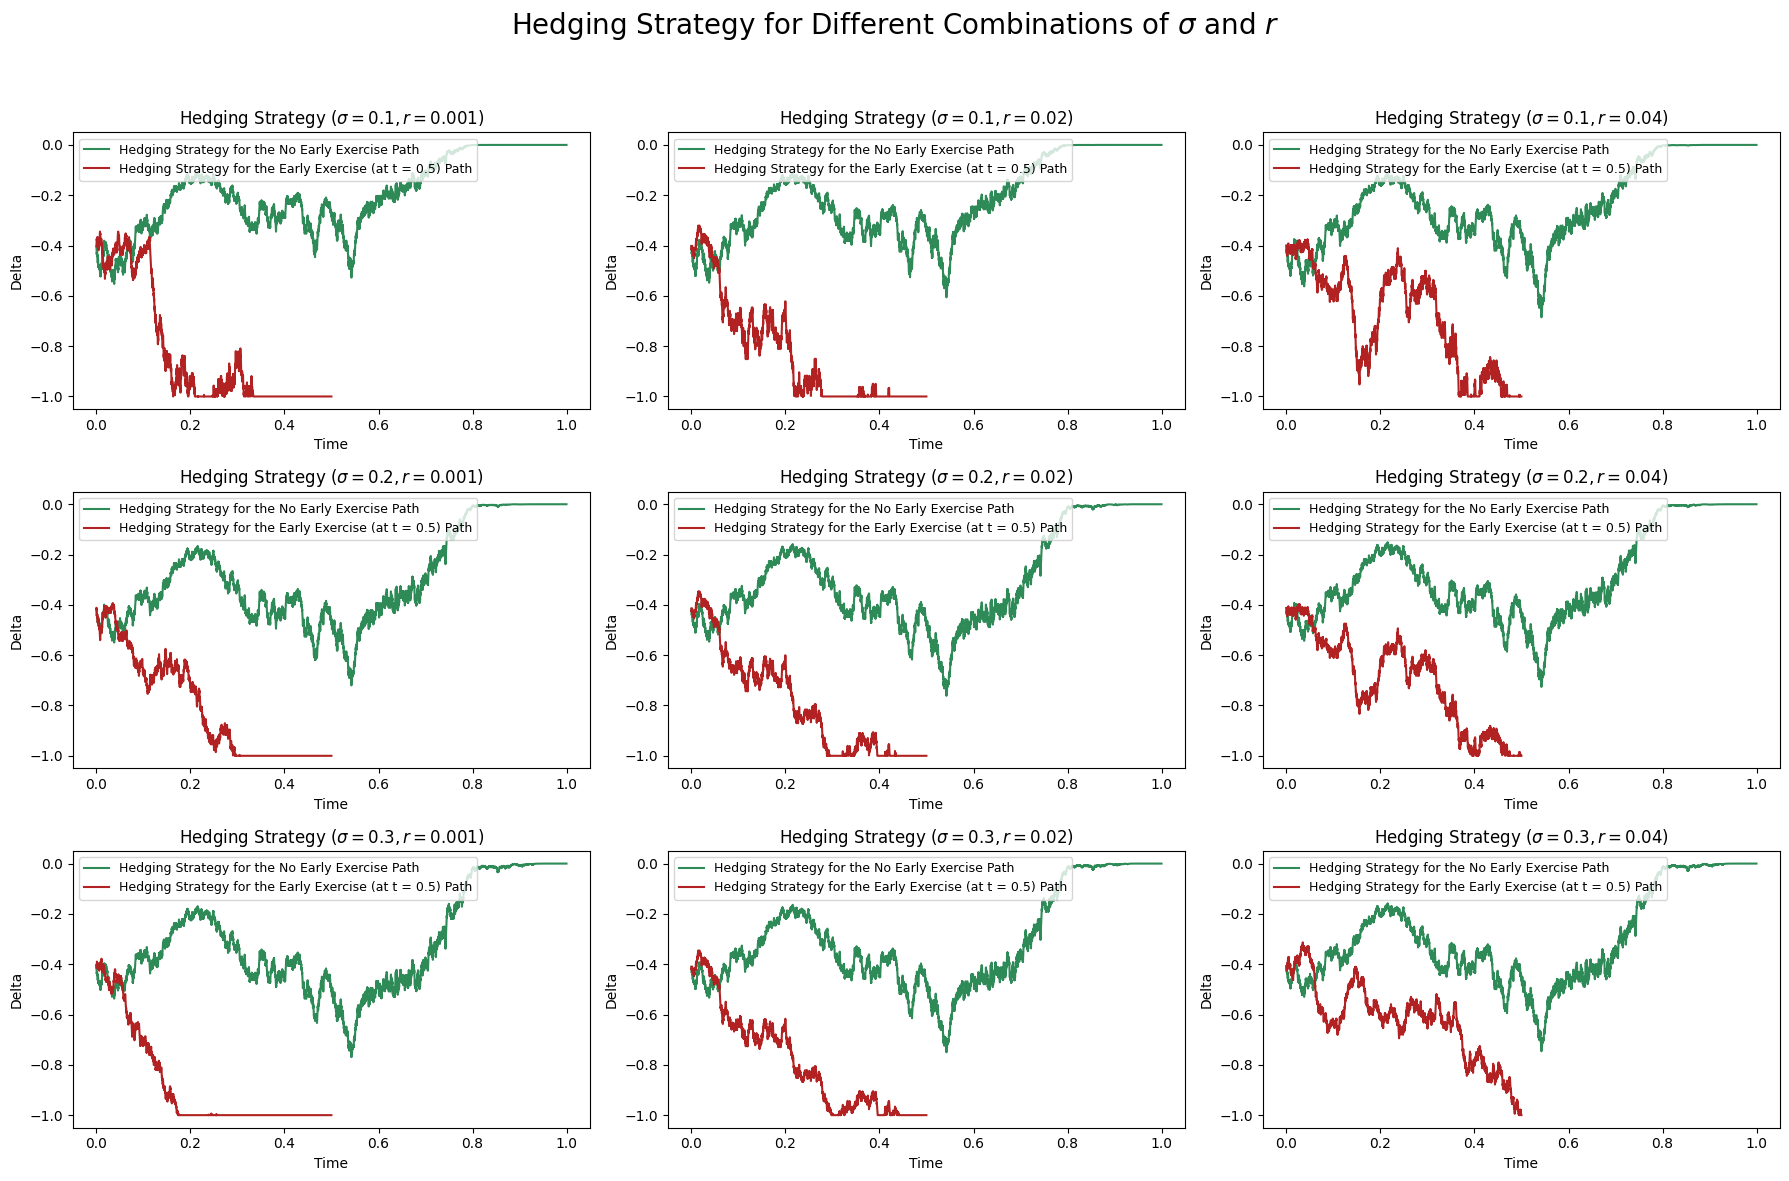

In [24]:
# Set values for σ (volatility) and r (risk-free rate)
sigma_values = [0.10, 0.20, 0.30]  # 10%, 20%, 30%
r_values = [0.001, 0.02, 0.04]      # 0%, 2%, 4%

# Create a 3x3 grid of subplots to plot for each combination of σ and r
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Hedging Strategy for Different Combinations of $\sigma$ and $r$", fontsize=20)

# Loop over all combinations of σ and r and plot in each subplot
for i, sigma in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        ax = axes[i, j]  # Select the appropriate subplot
        np.random.seed(0)
        plot_delta_hedging(sigma, r, ax=ax)  # Call the function with the specific axis

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Part (b)

Assume you have purchased the above American put option using the parameters $T=1$, $S_0=10$, $\mu=5\%$, $\sigma=20\%$, and the risk-free rate $r=2\%$. Use $N=5000$ and a strike $K=10$.

### i.

Simulate 10,000 sample paths of the asset and generate distributions for the P&L and distribution and the stopping time for a trader who purchased the option. Conditioned on those paths that are exercised (otherwise the distribution will have point masses), but record the probability of exercise to account for the point mass.

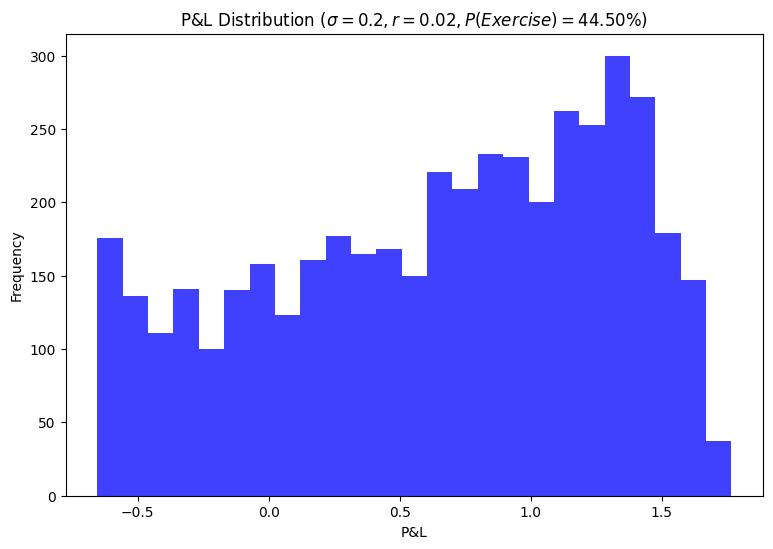

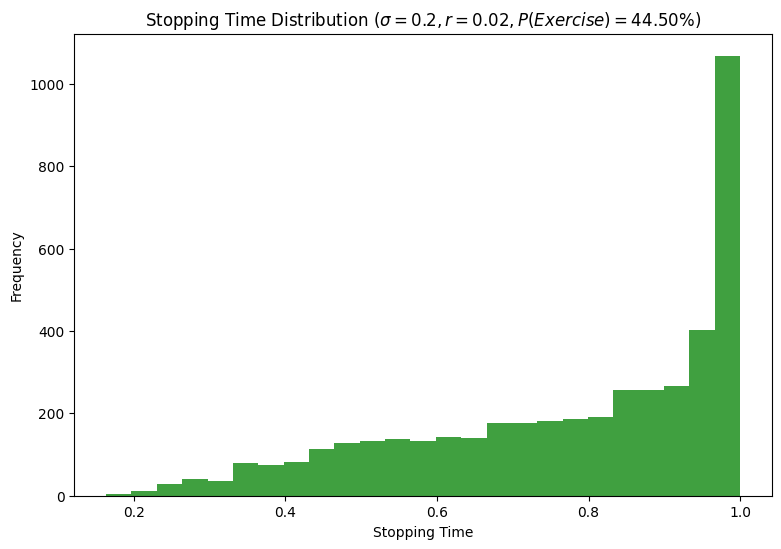

Probability of exercise: 44.50%


In [25]:
def simulate_sample_paths(sigma, r, T=1, S0=10, K=10, mu=0.05, N=5000, num_paths=10000):
    dt = T / N
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))
    p_physical = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(dt))

    paths = np.zeros((num_paths, N + 1))
    paths[:, 0] = S0

    for i in range(1, N + 1):
        rand_vals = np.random.rand(num_paths)
        up_move = rand_vals < p_physical
        down_move = rand_vals >= p_physical
        paths[up_move, i] = paths[up_move, i - 1] * u
        paths[down_move, i] = paths[down_move, i - 1] * d

    return paths

def calculate_pnl_stopping_time(paths, boundary_prices, times, K, premium, r):
    num_paths = paths.shape[0]
    pnl = np.zeros(num_paths)
    stopping_time = np.full(num_paths, np.nan)

    for i in range(num_paths):
        exercised = False
        for t_idx, time in enumerate(times):
            if paths[i, t_idx] < boundary_prices[t_idx]:
                # Early exercise: Discount the payoff to the time of exercise
                pnl[i] = (K - paths[i, t_idx]) * np.exp(-r * time) - premium
                stopping_time[i] = time
                exercised = True
                break
        if not exercised:
            # Maturity: Discount the payoff to the present, or lose premium if OTM
            final_payoff = max(K - paths[i, -1], 0) * np.exp(-r * times[-1])
            pnl[i] = final_payoff - premium

    return pnl, stopping_time

def plot_pnl_stopping_time(sigma, r, T=1, S0=10, K=10, mu=0.05, N=5000, num_paths=10000):
    boundary, times, boundary_prices, premium = plot_exercise_boundary(sigma, r, ax=ax)
    paths = simulate_sample_paths(sigma, r, T, S0, K, mu, N, num_paths)
    pnl, stopping_time = calculate_pnl_stopping_time(paths, boundary_prices, times, K, premium, r)
    prob_exercise = np.sum(~np.isnan(stopping_time)) / num_paths

    # Plot P&L distribution
    fig_pnl, ax_pnl = plt.subplots(figsize=(9, 6))
    ax_pnl.hist(pnl[~np.isnan(stopping_time)], bins=25, alpha=0.75, color="blue")
    ax_pnl.set_title(f"P&L Distribution ($\sigma={sigma}, r={r}, P(Exercise) = {prob_exercise * 100:.2f}\%$)")
    ax_pnl.set_xlabel("P&L")
    ax_pnl.set_ylabel("Frequency")
    plt.show()

    # Plot Stopping Time distribution
    fig_stop, ax_stop = plt.subplots(figsize=(9, 6))
    ax_stop.hist(stopping_time[~np.isnan(stopping_time)], bins=25, alpha=0.75, color='green')
    ax_stop.set_title(f"Stopping Time Distribution ($\sigma={sigma}, r={r}, P(Exercise) = {prob_exercise * 100:.2f}\%$)")
    ax_stop.set_xlabel("Stopping Time")
    ax_stop.set_ylabel("Frequency")
    plt.show()

    print(f"Probability of exercise: {prob_exercise * 100:.2f}%")

# Run the simulation and plot the results for σ = 0.2 and r = 0.02
np.random.seed(0)
plot_pnl_stopping_time(sigma=0.2, r=0.02)


### ii.

Repeat the above for various values of $r$ and $\sigma$.

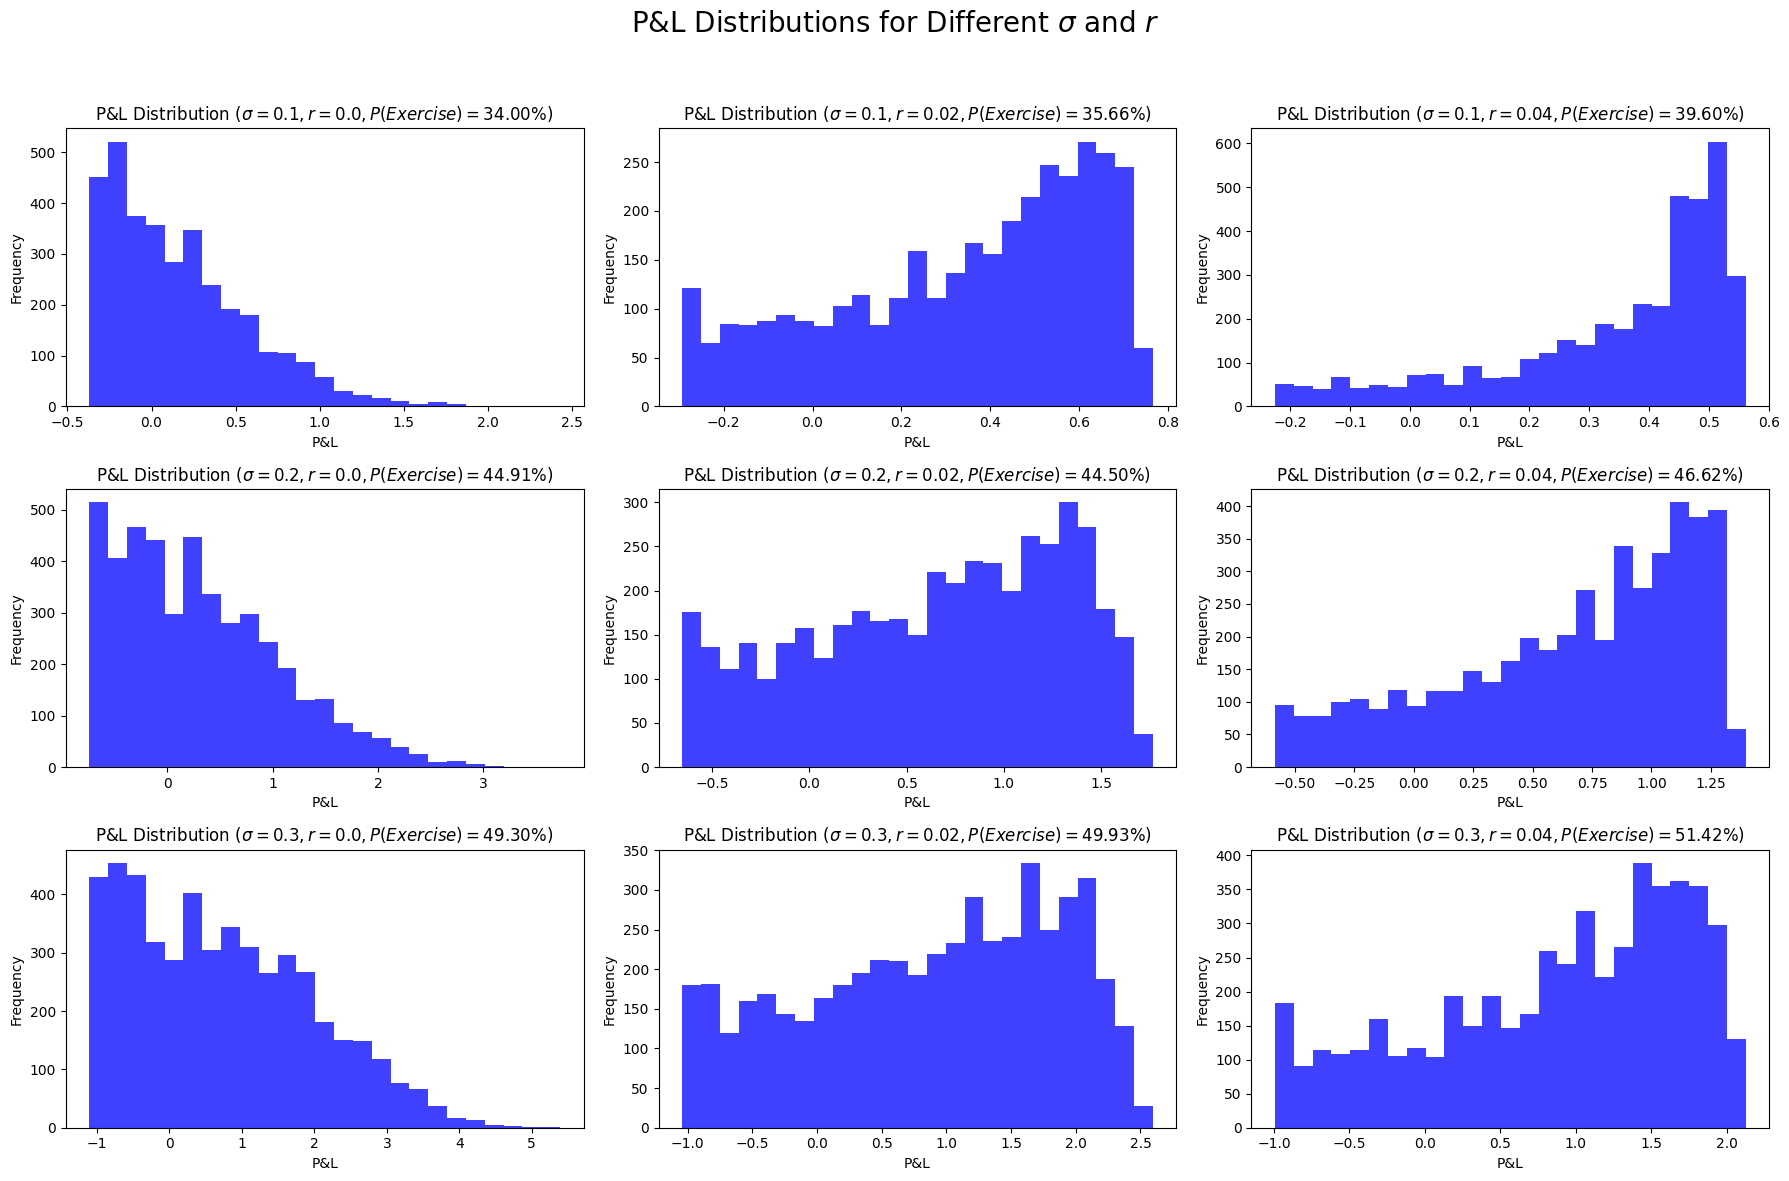

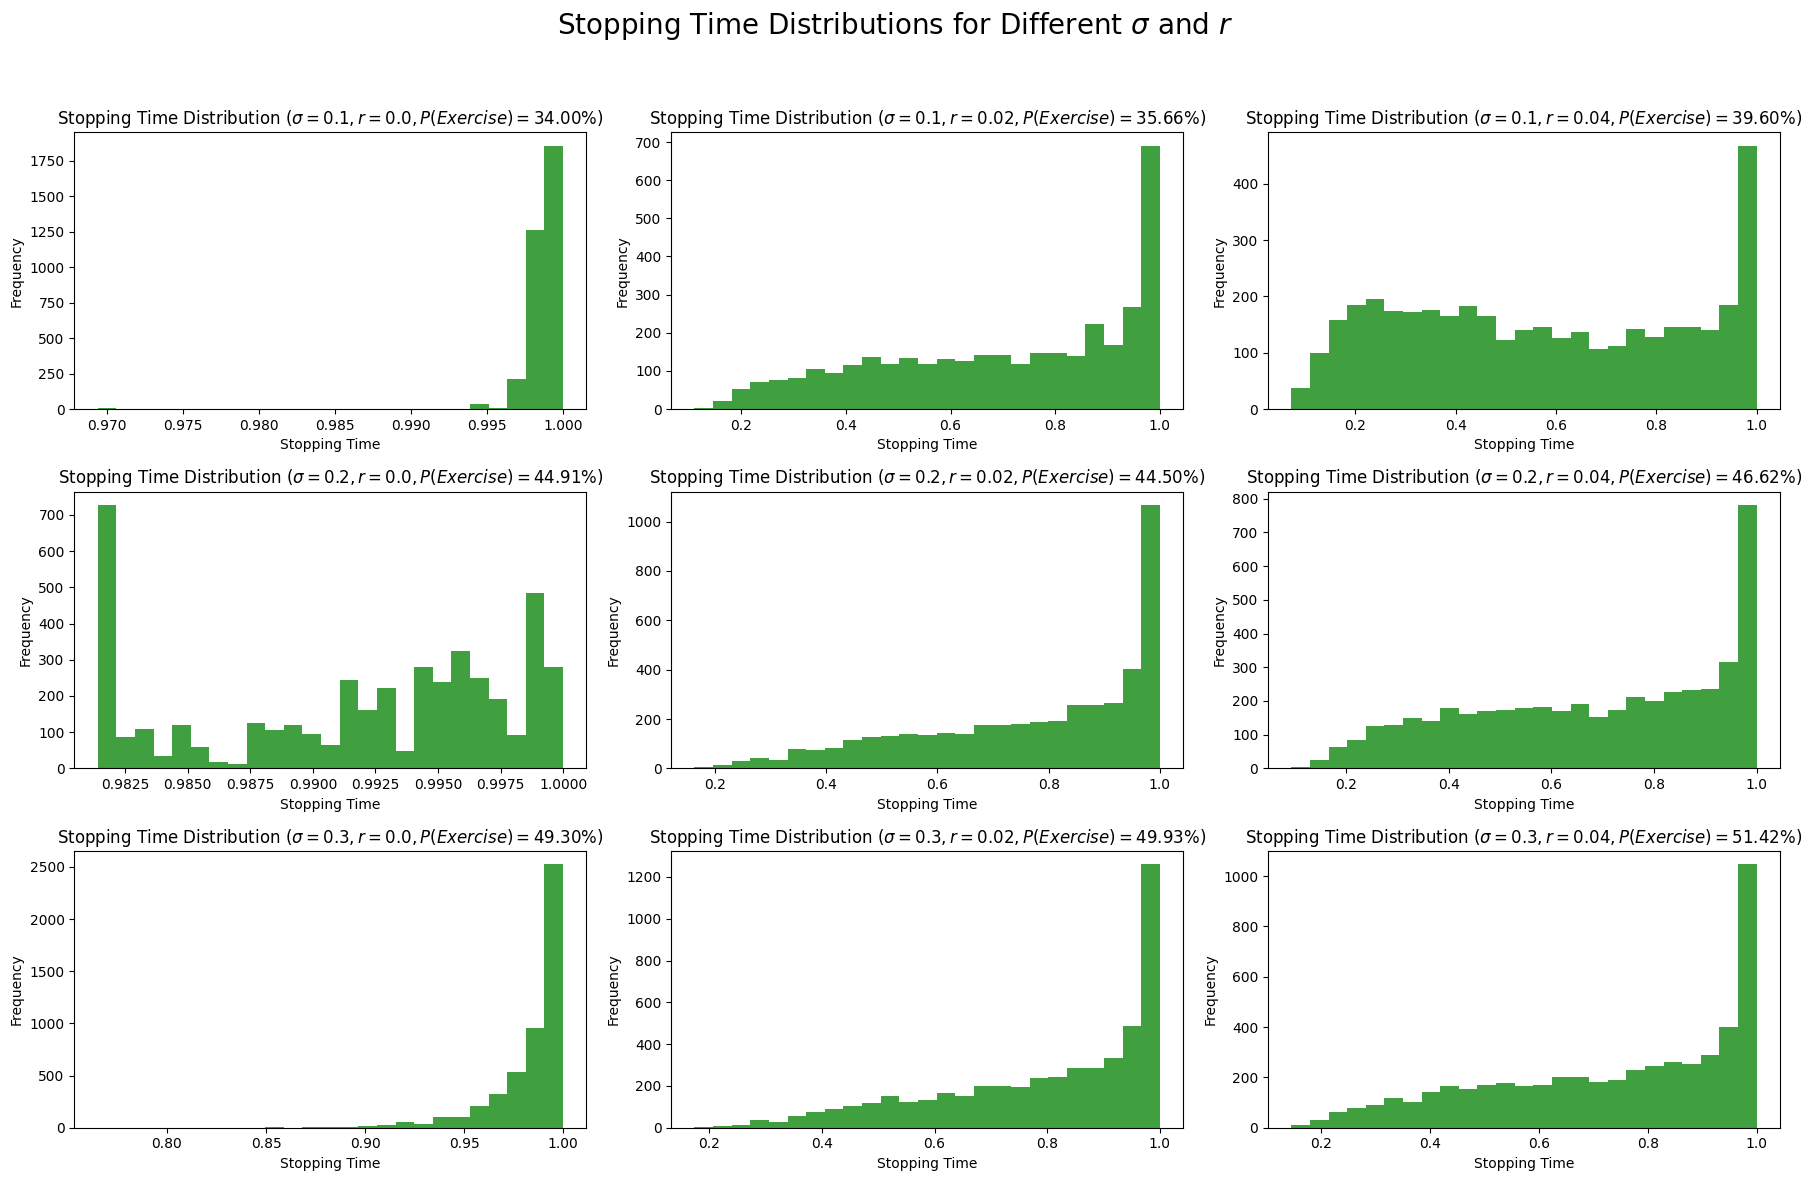

In [26]:
def plot_pnl_stopping_time(sigma, r, ax_pnl, ax_stop, T=1, S0=10, K=10, mu=0.05, N=5000, num_paths=10000):
    boundary, times, boundary_prices, premium = plot_exercise_boundary(sigma, r, ax=ax)
    paths = simulate_sample_paths(sigma, r, T, S0, K, mu, N, num_paths)
    pnl, stopping_time = calculate_pnl_stopping_time(paths, boundary_prices, times, K, premium, r)
    prob_exercise = np.sum(~np.isnan(stopping_time)) / num_paths

    # Plot P&L distribution
    #fig_pnl, ax_pnl = plt.subplots(figsize=(9, 6))
    ax_pnl.hist(pnl[~np.isnan(stopping_time)], bins=25, alpha=0.75, color="blue")
    ax_pnl.set_title(f"P&L Distribution ($\sigma={sigma}, r={r}, P(Exercise) = {prob_exercise * 100:.2f}\%$)")
    ax_pnl.set_xlabel("P&L")
    ax_pnl.set_ylabel("Frequency")
    #plt.show()

    # Plot Stopping Time distribution
    #fig_stop, ax_stop = plt.subplots(figsize=(9, 6))
    ax_stop.hist(stopping_time[~np.isnan(stopping_time)], bins=25, alpha=0.75, color='green')
    ax_stop.set_title(f"Stopping Time Distribution ($\sigma={sigma}, r={r}, P(Exercise) = {prob_exercise * 100:.2f}\%$)")
    ax_stop.set_xlabel("Stopping Time")
    ax_stop.set_ylabel("Frequency")
    #plt.show()

# Parameters
sigma_values = [0.10, 0.20, 0.30]
r_values = [0.00, 0.02, 0.04]

fig_pnl, axes_pnl = plt.subplots(3, 3, figsize=(18, 12))
fig_stop, axes_stop = plt.subplots(3, 3, figsize=(18, 12))

fig_pnl.suptitle("P&L Distributions for Different $\sigma$ and $r$", fontsize=20)
fig_stop.suptitle("Stopping Time Distributions for Different $\sigma$ and $r$", fontsize=20)

for i, sigma in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        np.random.seed(0)
        plot_pnl_stopping_time(
            sigma, r,
            ax_pnl=axes_pnl[i, j],
            ax_stop=axes_stop[i, j]
        )

fig_pnl.tight_layout(rect=[0, 0, 1, 0.95])
fig_stop.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### iii.

Suppose that the realized volatility is $\sigma = 10\%, 15\%, 20\%, 25\%, 30\%$, but you were able to purchase the option with a volatility of $\sigma = 20\%$ and you use the $\sigma = 20\%$ exercise boundary in your trading strategy. Explore how the distributions of profit and loss and exercise time vary in this case.

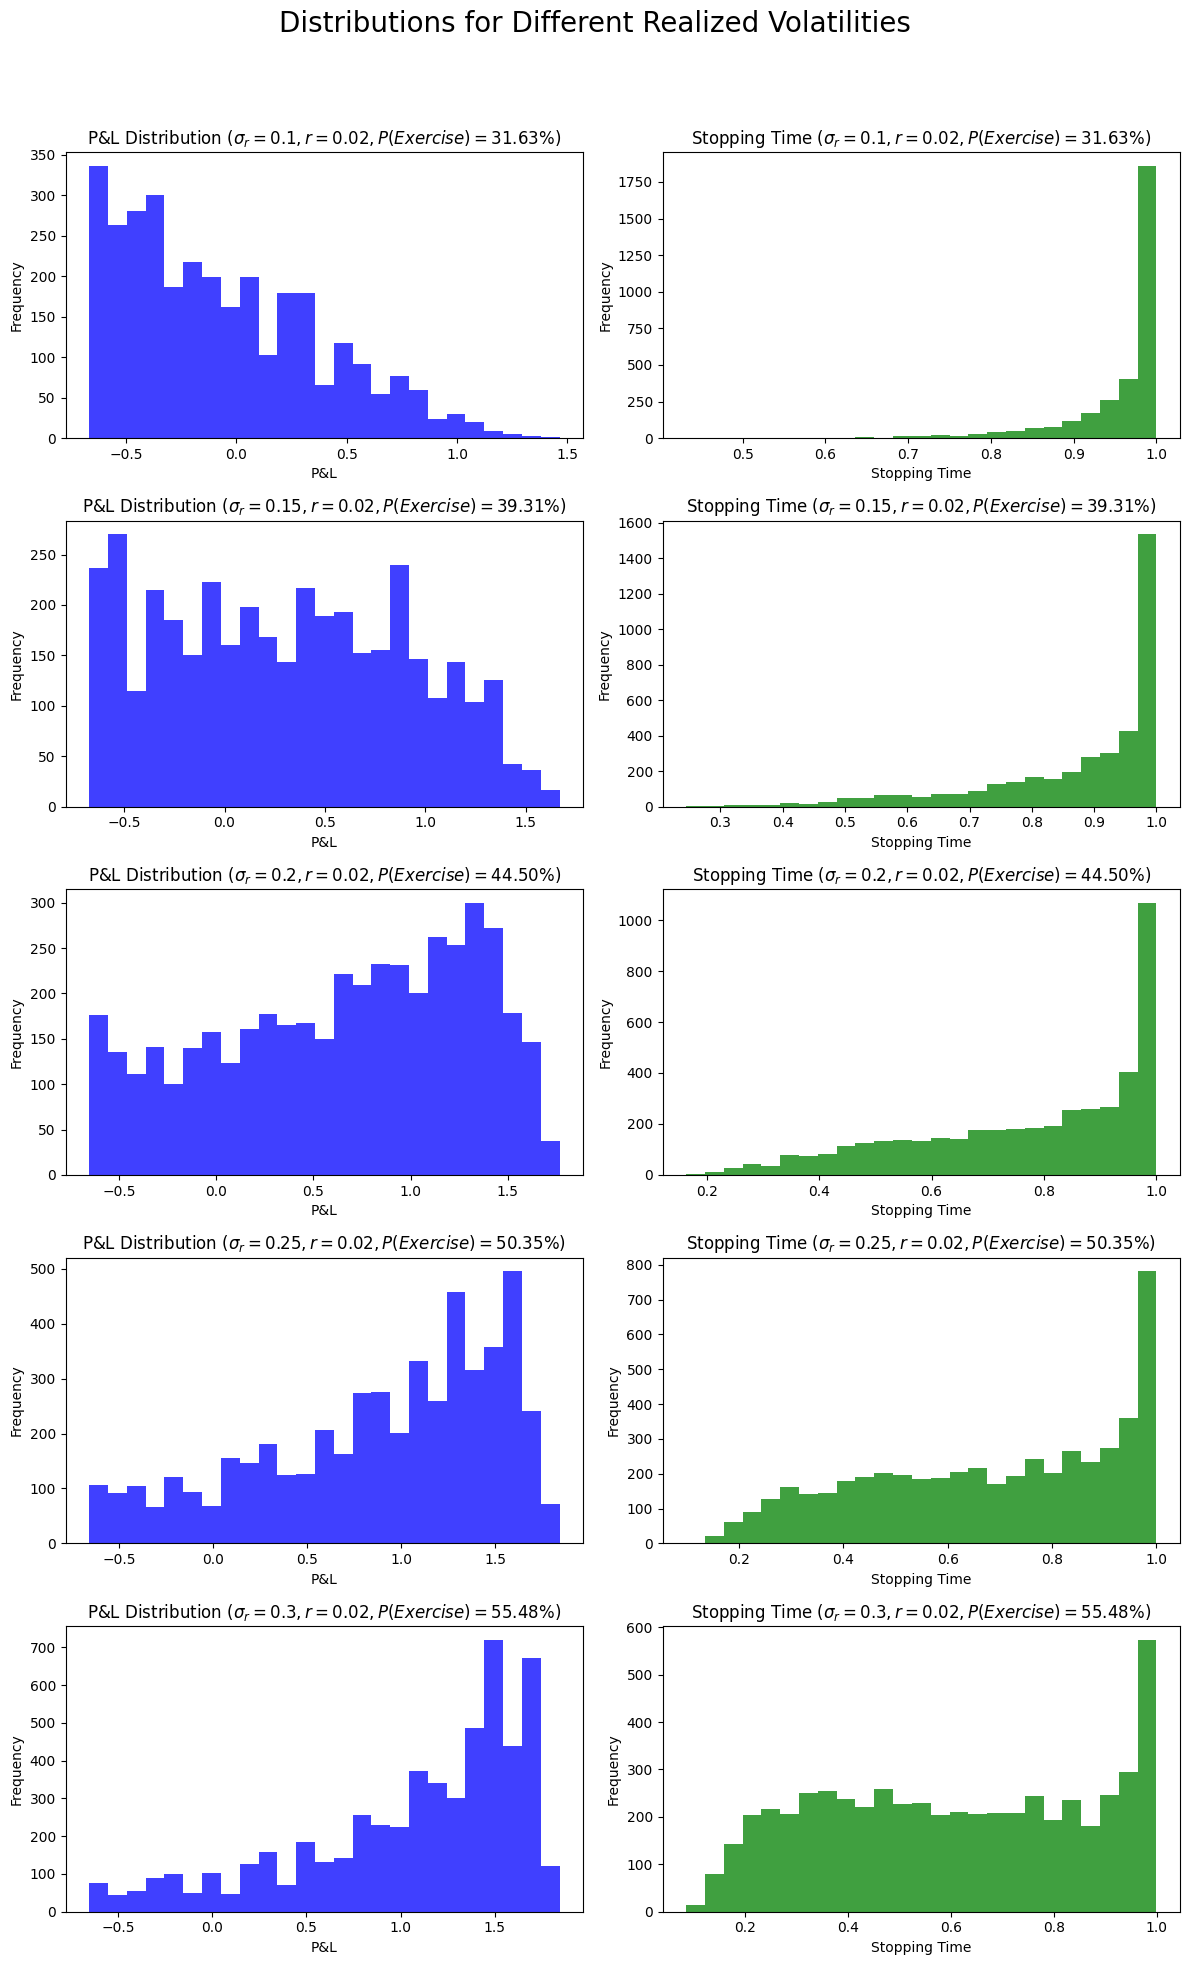

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pnl_stopping_time(sigma, r, ax_pnl, ax_stop, T=1, S0=10, K=10, mu=0.05, N=5000, num_paths=10000):
    # Use sigma=0.2 in the exercise boundary for consistency
    boundary, times, boundary_prices, premium = plot_exercise_boundary(sigma=0.2, r=0.02, ax=ax)
    paths = simulate_sample_paths(sigma, r, T, S0, K, mu, N, num_paths)
    pnl, stopping_time = calculate_pnl_stopping_time(paths, boundary_prices, times, K, premium, r)
    prob_exercise = np.sum(~np.isnan(stopping_time)) / num_paths

    # Plot P&L distribution
    ax_pnl.hist(pnl[~np.isnan(stopping_time)], bins=25, alpha=0.75, color="blue")
    ax_pnl.set_title(f"P&L Distribution ($\sigma_r={sigma}, r={r}, P(Exercise)={prob_exercise*100:.2f}\%$)")
    ax_pnl.set_xlabel("P&L")
    ax_pnl.set_ylabel("Frequency")

    # Plot Stopping Time distribution
    ax_stop.hist(stopping_time[~np.isnan(stopping_time)], bins=25, alpha=0.75, color="green")
    ax_stop.set_title(f"Stopping Time ($\sigma_r={sigma}, r={r}, P(Exercise)={prob_exercise*100:.2f}\%$)")
    ax_stop.set_xlabel("Stopping Time")
    ax_stop.set_ylabel("Frequency")

# Parameters
sigma_realized_values = [0.10, 0.15, 0.20, 0.25, 0.30]  # Realized volatilities

# Create a figure for P&L and Stopping Time with vertical subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns (P&L and Stopping Time)
fig.suptitle("Distributions for Different Realized Volatilities", fontsize=20)

# Loop over each realized sigma value to plot P&L and Stopping Time
for i, sigma_realized in enumerate(sigma_realized_values):
    np.random.seed(0)  # Ensure reproducibility
    plot_pnl_stopping_time(
        sigma_realized, r=0.02,
        ax_pnl=axes[i, 0],  # Left column for P&L
        ax_stop=axes[i, 1]  # Right column for Stopping Time
    )

# Adjust layout and show the plots
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
